# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Install Pacakges</div>

In [1]:
!pip install datasets lxml --quiet

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Import Libraries</div>

In [2]:
from collections import OrderedDict

from typing import List, Tuple, Dict

import numpy as np

import pandas as pd

import logging

from datetime import datetime

import shutil

import os

import torchvision.models as models

from scipy import spatial

from sklearn.cluster import AffinityPropagation

from datasets.utils.logging import disable_progress_bar

import torch
import ast
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import transforms
from torchvision.transforms import (

    ToTensor,

    Normalize,

    Compose,

    Resize,

    Grayscale,

    RandomHorizontalFlip,

    RandomRotation,

)
import math
from torch.optim.lr_scheduler import CyclicLR, ReduceLROnPlateau

from torchvision.datasets import CIFAR10, MNIST, FashionMNIST

import torch.nn as nn

import torchmetrics

from torch import nn, optim

import torch.nn.functional as F

import csv

import copy

from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

from sklearn.manifold import MDS

import xml.etree.ElementTree as ET

from lxml import etree

import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

import seaborn as sns




# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Make Directories</div>

In [3]:
!mkdir models
!mkdir models/before_aggregation
!mkdir sensitive_id
!mkdir results

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/before_aggregation’: File exists
mkdir: cannot create directory ‘sensitive_id’: File exists
mkdir: cannot create directory ‘results’: File exists


In [4]:
log_path = datetime.now().strftime("%Y-%m-%d_%H-%M-%S_")

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

log_file = log_path + ".log"

os.mkdir(log_path)

open(log_file, "a").close()

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Configs</div>

In [5]:
seed = 1

random.seed(seed)

np.random.seed(seed)

torch.manual_seed(seed)

torch.cuda.manual_seed(seed)

sns.set_theme(style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus":False})

warnings.filterwarnings('ignore')



num_shards_per_class = 20

num_clients = 10

num_classes=10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Clustering_method="Mask"# Weight, Mask

Clustering_period = 5

cluster_number=3

FL_rounds = 6

Sensitivity_percentage = 0.1


dataset_type="cifar" #cifar, mnist

model_type="resnet18" #resnet18, mobilenet, vgg16, cnn

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">XML</div>

In [6]:
xml_content = '''
<Assignment>
<Node id="0">
<DataPair classLabel="1" shard="3"/>
<DataPair classLabel="2" shard="11"/>
<DataPair classLabel="3" shard="18"/>
<DataPair classLabel="2" shard="5"/>
</Node>
<Node id="1">
<DataPair classLabel="2" shard="5"/>
<DataPair classLabel="3" shard="0"/>
<DataPair classLabel="3" shard="10"/>
<DataPair classLabel="1" shard="1"/>
</Node>
<Node id="2">
<DataPair classLabel="3" shard="13"/>
<DataPair classLabel="1" shard="1"/>
<DataPair classLabel="2" shard="8"/>
<DataPair classLabel="2" shard="3"/>
</Node>
<Node id="3">
<DataPair classLabel="2" shard="10"/>
<DataPair classLabel="1" shard="12"/>
<DataPair classLabel="3" shard="16"/>
<DataPair classLabel="1" shard="9"/>
</Node>
<Node id="4">
<DataPair classLabel="5" shard="18"/>
<DataPair classLabel="4" shard="17"/>
<DataPair classLabel="6" shard="2"/>
<DataPair classLabel="4" shard="18"/>
</Node>
<Node id="5">
<DataPair classLabel="4" shard="13"/>
<DataPair classLabel="6" shard="6"/>
<DataPair classLabel="5" shard="11"/>
<DataPair classLabel="6" shard="4"/>
</Node>
<Node id="6">
<DataPair classLabel="6" shard="17"/>
<DataPair classLabel="5" shard="4"/>
<DataPair classLabel="4" shard="7"/>
<DataPair classLabel="5" shard="11"/>
</Node>
<Node id="7">
<DataPair classLabel="10" shard="17"/>
<DataPair classLabel="8" shard="12"/>
<DataPair classLabel="9" shard="2"/>
<DataPair classLabel="7" shard="16"/>
</Node>
<Node id="8">
<DataPair classLabel="9" shard="19"/>
<DataPair classLabel="8" shard="0"/>
<DataPair classLabel="9" shard="5"/>
<DataPair classLabel="7" shard="15"/>
</Node>
<Node id="9">
<DataPair classLabel="8" shard="9"/>
<DataPair classLabel="9" shard="14"/>
<DataPair classLabel="10" shard="7"/>
<DataPair classLabel="7" shard="13"/>
</Node>
</Assignment>

'''


In [7]:
def parse_xml_assignments():

    root = ET.fromstring(xml_content)

    node_assignments = {}

    for node in root.findall("Node"):

        node_id = int(node.get("id"))

        shards = [

            (int(dp.get("classLabel")), int(dp.get("shard")))

            for dp in node.findall("DataPair")

        ]

        node_assignments[node_id] = shards

    return node_assignments

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Non-IID Distribution</div>

In [8]:
class Dataset:

    def __init__(self):

        self.num_classes = 10

        self.num_shards_per_class = 4

        if dataset_type=="cifar" and model_type == "resnet18":

            self.transform = Compose(

                [

                    ToTensor(),

                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

                ]

            )
        elif dataset_type=="cifar" and model_type == "cnn":

            self.transform = Compose(
                [
                    ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                ]
            )

        elif dataset_type=="cifar" and model_type == "mobilenet":

            self.transform = transforms.Compose([

                transforms.Resize((224, 224)),

                transforms.ToTensor(),

            ])
              
        elif dataset_type=="cifar" and model_type == "alex":

            self.transform = transforms.Compose([transforms.Resize((70, 70)),
                                       transforms.RandomCrop((64, 64)),
                                       transforms.ToTensor()])

        # elif dataset_type=="cifar" and model_type == "alexnet":

        #     self.transform = transforms.Compose([

        #         Resize(224),

        #         ToTensor(),

        #         Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.25))

        #      ])

        else:

            """

            TODO:‌ find the usage, I don't know what is this composer for!

            """

            self.transform = Compose([

                Resize(224),

                Grayscale(num_output_channels=3),

                ToTensor(),

                Normalize((0.1307,), (0.3081,)),

            ])

            

    def load_cifar_10_dataset(self):

        train = CIFAR10(root="./data", train=True, download=True, transform=self.transform)

        test = CIFAR10(root="./data", train=False, download=True, transform=self.transform)

        return train, test



    def load_mnist_dataset(self):

        train = MNIST(root="./data", train=True, download=True, transform=self.transform)

        test = MNIST(root="./data", train=False, download=True, transform=self.transform)

        return train, test



    def load_fashion_mnist_dataset(self):

        train = FashionMNIST(root="./data", train=True, download=True, transform=self.transform)

        test = FashionMNIST(root="./data", train=False, download=True, transform=self.transform)

        return train, test



    def load_shards_from_xml_file(self, xml_file, train, test, num_clients):

        node_assignments = parse_xml_assignments()

        train_data_indices = {

            i: np.array([], dtype="int64") for i in range(num_clients)

        }



        test_data_indices = {i: np.array([], dtype="int64") for i in range(num_clients)}

        train_shards, _ = self.divide_class_into_shards(train, 10, 20)

        test_shards, _ = self.divide_class_into_shards(test, 10, 20)

        trainLoaders = []

        testLoaders = []





        for node in range(num_clients):

            shard_ids = node_assignments[node]

            indices_tr = [

                (shard_id[0] - 1) * 20 + shard_id[1] for shard_id in shard_ids

            ]



            indices_ts = [

                (shard_id[0] - 1) * 20 + random.randint(1, 19) for shard_id in shard_ids

            ]



            train_indices = np.concatenate([train_shards[idx] for idx in indices_tr])

            test_indices = np.concatenate([test_shards[idx] for idx in indices_ts])

            train_loader = DataLoader(

                Subset(train, train_indices), batch_size=256, shuffle=True #batch_size=64

            )



            trainLoaders.append(train_loader)

            test_loader = DataLoader(

                Subset(test, test_indices), batch_size=256, shuffle=True #batch_size=64

            )



            testLoaders.append(test_loader)



        return trainLoaders, testLoaders

        return 1



    def divide_class_into_shards(self, dataset, num_classes: int, num_shards_per_class: int):

        num_shards = num_classes * num_shards_per_class

        num_imgs = int(len(dataset) / num_shards_per_class / num_classes)

        ## Create a list to store indices for each class

        class_indices = [[] for _ in range(num_classes)]

        labels = np.array(dataset.targets)

        # Group the indices of each class

        for idx, label in enumerate(labels):

            class_indices[label].append(idx)

        # Shuffle indices within each class

        for i in range(num_classes):

            np.random.shuffle(class_indices[i])



        shards = []

        for i in range(num_classes):

            for j in range(num_shards_per_class):

                shards.append(class_indices[i][j * num_imgs : (j + 1) * num_imgs])

        shards = np.array(shards, dtype="object")

        return shards, num_shards



    def noniid_split(self, dataset, num_classes: int, num_clients: int, num_shards_per_class: int):

        shards, num_shards = self.divide_class_into_shards(

            dataset, num_classes, num_shards_per_class

        )

        client_data_indices = {

            i: np.array([], dtype="int64") for i in range(num_clients)

        }



        shards_per_client = 4

        shards_assignments = np.zeros(num_shards, dtype=bool)

        classes = []



        for client in range(num_clients):

            assigned_shards = []

            classes_assigned = []



            while len(assigned_shards) < shards_per_client:

                shard_idx = np.random.choice(np.where(shards_assignments == False)[0])

                class_idx = shard_idx // num_shards_per_class

                if class_idx not in classes_assigned:

                    assigned_shards.append(shard_idx)

                    classes_assigned.append(class_idx)

                    shards_assignments[shard_idx] = True

            classes.append(classes_assigned)

            print(classes_assigned)

            for shard in assigned_shards:

                client_data_indices[client] = np.concatenate(

                    (client_data_indices[client], shards[shard]), axis=0

                )

        return client_data_indices, classes



    def partition_test_data_based_on_train(

        self,

        dataset,

        train_idx,

        num_classes: int,

        num_clients: int,

        num_shards_per_class: int,

    ):

        shards, num_shards = self.divide_class_into_shards(

            dataset, num_classes, num_shards_per_class

        )

        ## Ensure each client gets 2 shards from different classes

        client_data_indices = {

            i: np.array([], dtype="int64") for i in range(num_clients)

        }



        shards_per_client = 4

        shards_assignments = np.zeros(num_shards, dtype=bool)

        classes = []





        for client in range(num_clients):

            assigned_shards = []

            classes_assigned = []



            while len(assigned_shards) < shards_per_client:

                class_idx = train_idx[client][len(assigned_shards)]

                # shard_idx = np.random.choice(np.where(shards_assignments == False)[0])

                shard_idx = class_idx * 20 + random.randint(1, 19)

                print("shard, class", shard_idx, class_idx)

                assigned_shards.append(shard_idx)

                classes_assigned.append(class_idx)

                # if class_idx not in classes_assigned:

                # assigned_shards.append(shard_idx)

                # classes_assigned.append(class_idx)

                # shards_assignments[shard_idx] = True

            classes.append(classes_assigned)

            print(classes_assigned)

            for shard in assigned_shards:

                client_data_indices[client] = np.concatenate((client_data_indices[client], shards[shard]), axis=0)



        return client_data_indices



    def get_dataloaders(self, dataset, indices, batch_size):

        loaders = []

        for client_idx in indices:

            subset = Subset(dataset, indices[client_idx])

            loader = DataLoader(subset, batch_size=batch_size, shuffle=True)

            loaders.append(loader)



        return loaders

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Model Network</div>

In [9]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()

        if model_type == "resnet18":
            self.resnet18 = models.resnet18(pretrained=False)
            if dataset_type == "mnist":
                self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)

        elif model_type == "cnn":
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        elif model_type == "mobilenet":
            self.mobilenet = models.mobilenet_v2(pretrained=False)
            self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)

        elif model_type == "vgg16":
            self.vgg16 = models.vgg16(pretrained=False)
            self.vgg16.classifier[6] = nn.Linear(self.vgg16.classifier[6].in_features, num_classes)
        elif model_type == "alex":
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
            self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes)
            )

    def forward(self, x):
        out = None

        if model_type == "resnet18":
            out = self.resnet18(x)
        elif model_type == "cnn":
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            out = x

            out = x
        elif model_type == "mobilenet":
            out = self.mobilenet(x)
        elif model_type == "vgg16":
            out = self.vgg16(x)
        elif model_type == "alex":
            x = self.features(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), 256 * 6 * 6)
            logits = self.classifier(x)
            probas = F.softmax(logits, dim=1)
            return logits

        return out


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Learning</div>

In [10]:
def calculate_accuracy(loader, model):

    correct = 0

    total = 0

    with torch.no_grad():

        for data in loader:

            images, labels = data

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()



    return 100 * correct / total

def train(net, node_id, trainloader, epochs: int=10):

    """Train the network on the training set."""

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters(),         
        lr=0.0001,
        betas=(0.9, 0.999),
        eps=1e-7,
        weight_decay=1e-4,)

    # scheduler = ReduceLROnPlateau(optimizer, 'min')

    net.train()



    for epoch in range(1): #range(epochs)

        correct, total, epoch_loss = 0, 0, 0.0

        for images, labels in trainloader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = net(images)

            """

            if isinstance(outputs, tuple):

              outputs, aux1, aux2 = outputs

              loss = criterion(outputs, labels) + 0.3 * criterion(aux1, labels) + 0.3 * criterion(aux2, labels)

            else:

              loss = criterion(outputs, labels)

            """



            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            # Metrics

            epoch_loss += loss

            total += labels.size(0)

            ## outputs.data

            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()



    loss /= len(trainloader.dataset)

    acc = correct / total

    model_path = f"models/node_{node_id}.pth"

    torch.save(net.state_dict(), model_path)

    return acc, loss

    

def test(net, testloader):

    """Evaluate the network on the entire test set."""

    criterion = torch.nn.CrossEntropyLoss()

    correct, total, loss = 0, 0, 0.0

    net.eval()



    with torch.no_grad():

        for images, labels in testloader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = net(images)

            ## For googlenet model

            """

            if isinstance(outputs, tuple):

              outputs, _, _ = outputs

            """

            loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)

    accuracy = correct / total

    # print(f" test loss {loss}, accuracy {accuracy}")

    return accuracy, loss

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Client</div>

In [11]:
class Client:

    def __init__(self, net, node_id, trainloader, testloader):

        self.net = net.to(DEVICE)

        self.trainloader = trainloader

        self.testloader = testloader

        self.node_id = node_id

        self.train_acc, self.test_acc = 0.0, 0.0

        self.global_net = Net().to(DEVICE)



    # def train_test(self):

    #     self.train_acc,_=

    #     self.test_acc

    def set_bias(self, pref, bias):

        self.bias = bias

        self.pref = pref

    def set_shard(self, shard):

        self.shard = shard

    def get_global_net(self):

        return self.global_net

    def setting_parameters(self, parameters: List[np.ndarray]):

        params_dict = zip(self.net.state_dict().items(), parameters)

        state_dict = OrderedDict({k: torch.Tensor(v).to(DEVICE) for k, v in params_dict})

        self.net.load_state_dict(state_dict, strict=True)

    def getting_parameters(self) -> List[np.ndarray]:

        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    # def get_parameters(self):

    # return getting_parameters()

    def fit(self, parameters):

        self.setting_parameters(parameters)

        train(self.net, self.node_id, self.trainloader, epochs=10)

        return self.getting_parameters(), len(self.trainloader), {}



    def evaluate(self, parameters):

        self.setting_parameters(parameters)

        loss, accuracy = test(self.net, self.testloader)

        return float(loss), len(self.testloader), {"accuracy": float(accuracy)}



    def Train_test_and_return_acc(self):

        self.train_acc, _ = train(self.net, self.node_id, self.trainloader, 1)


        self.test_acc, _ = test(self.net, self.testloader)


        return self.train_acc, self.test_acc

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Server</div>

In [12]:
def divide_nested_list(nested_list, divisor):

    for i in range(len(nested_list)):

        if isinstance(nested_list[i], list):

            divide_nested_list(nested_list[i], divisor)

        else:

            nested_list[i] /= divisor

    return nested_list



def zero_nested_list(nested_list):

    for i in range(len(nested_list)):

        if isinstance(nested_list[i], list):

            zero_nested_list(nested_list[i])

        else:

            nested_list[i] = 0

    return nested_list





class Server:

    def __init__(self):

        self.models = []



    def append_model(self, model: nn.Module):

        if not isinstance(model, nn.Module):

            raise TypeError("Only instances of nn.Module can be appended")

        self.models.append(model)



    def aggregate(self):

        if not self.models:

            raise ValueError("No models added to the server.")

        print("model numbers:", len(self.models))



        device = next(self.models[0].parameters()).device



        for model in self.models:

            model.to(device)



        avg_model = Net().to(device)



        with torch.no_grad():

            for param_name, avg_param in avg_model.named_parameters():

                temp = torch.zeros_like(avg_param)

                for model in self.models:

                    model_param = dict(model.named_parameters())[param_name]

                    temp += model_param.data

                avg_param.copy_(temp / len(self.models))



        return avg_model


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Clustering</div>

In [13]:
def find_num_cluster(clusters):

    num_cluster = []

    for item in clusters:

        if item not in num_cluster:

            num_cluster.append(item)

    return len(num_cluster)



class Clustering:

    def __init__(self, clients, trainLoaders, percentage, Cluster_number):

        # self.models=models

        self.clients = clients

        self.num_nodes = len(clients)

        self.percentage = percentage

        self.Mask_Number = 0

        self.maskIds = []

        self.grads = []



        # self.sensitivity_values=[self.calculate_sensitivity(models[i],trainLoaders[i]) for i in range (len(models))]



        self.load_and_calculate_sensitivity(trainLoaders)



        # df = pd.read_csv("clients.csv")

        # self.maskIds=[self.get_maskIds(self.sensitivity_values[i]) for i in range (self.num_nodes)]

        # = df["mask_IDs"]

        # print("Mask IDs:",self.maskIds)

        self.Cluster_number = Cluster_number

        self.distances = self.calculate_distance()

        # print("Mask_Number:",self.Mask_Number)

        # print("dist:",self.distances)

        self.Clusters = self.make_clusters()

    def assign_save_ids_to_weights(self, model):

        weight_id_map = {}

        weight_id = 0

        for name, parameter in model.named_parameters():

            if "bias" not in name and parameter.requires_grad:

                weight_id_map[name] = {}

                num_weights = parameter.numel()

                for i in range(num_weights):

                    weight_id_map[name][i] = weight_id

                    weight_id += 1

        filename = "weight_to_id.csv"

        if not os.path.exists(filename):

            with open(filename, "w", newline="") as csvfile:

                writer = csv.writer(csvfile)

                writer.writerow(["Layer", "Weight Index", "Weight ID"])

                for layer_name, indices in weight_id_map.items():

                    for index, weight_id in indices.items():

                        writer.writerow([layer_name, index, weight_id])

        return weight_id_map

    

    def load_and_calculate_sensitivity(self, trainLoaders, log_dir="sensitive_id"):
        """
        Calculate sensitivity and save unique Mask IDs for each client to separate CSV files.
        """
        
        os.makedirs(log_dir, exist_ok=True)
        
        for cid in self.clients:
            log_file = os.path.join(log_dir, f"client_{cid}_weights_log.csv")
            
            with open(log_file, mode="w", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(["Mask IDs"])  # Single header row
                
                model = load_torch_model(cid).to(DEVICE)
                
                sensitivity_value = self.calculate_sensitivity(model, trainLoaders[int(cid)])
                
                weight_id_map = self.assign_save_ids_to_weights(load_torch_model(0).to(DEVICE))
                mask_ID, weights = self.get_maskIds(sensitivity_value, weight_id_map)
                
                unique_mask_ids = list(set(mask_ID))
                writer.writerow([','.join(map(str, unique_mask_ids))])
            
    
                self.maskIds.append(mask_ID)
                self.grads.append(weights)
            
            print(f"Model weights and sensitivity data for client #{cid} saved to {log_file}")
    




    def calculate_sensitivity(self, model, dataloader):

        model.train()

        criterion = nn.CrossEntropyLoss()

        gradient_sums = {}

        for name, param in model.named_parameters():

            if "bias" not in name:

                gradient_sums[name] = 0.0

                param.requires_grad_(True)

        for inputs, labels in dataloader:

            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)



            ## For googlenet model

            """

            if isinstance(outputs, tuple):

              outputs, aux1, aux2 = outputs



            """

            loss = criterion(outputs, labels)

            # Backward pass

            model.zero_grad()

            loss.backward()

            sensitivities = {}

            for name, parameter in model.named_parameters():

                if "bias" not in name and parameter.requires_grad:  # Exclude biases



                    ## For googlenet model

                    """

                    if parameter.grad is not None:

                      grads = parameter.grad.abs().view(-1).cpu().numpy()

                    """



                    grads = parameter.grad.abs().view(-1).cpu().numpy()

                    # grads = parameter.abs().view(-1).cpu().detach().numpy()



                    for i, grad in enumerate(grads):

                        sensitivities[(name, i)] = grad



            return sensitivities





    def get_maskIds(self, sensitivity_values_node, weight_id_map):

        num_weights = len(sensitivity_values_node)

        top_k = int(np.ceil(self.percentage * num_weights / 100))

        self.Mask_Number = top_k

        sorted_weights = sorted(

            sensitivity_values_node.items(), key=lambda item: item[1], reverse=True

        )[:top_k]



        weights = [weight for (layer, index), weight in sensitivity_values_node.items()]



        top_weight_ids = [weight_id_map[layer][index] for (layer, index), _ in sorted_weights]



        return top_weight_ids, weights



    def normalize_distance(self, distances):

        min1 = np.min(np.ma.masked_equal(distances, 0))

        max1 = np.max(np.ma.masked_equal(distances, 0))

        normal_distances = np.zeros((self.num_nodes, self.num_nodes))

        for i in range(self.num_nodes):

            normal_distances[i][i] = 0

            for j in range(i + 1, self.num_nodes):

                normal_distances[i][j] = normal_distances[j][i] = (

                    distances[i][j] - min1

                ) / (max1 - min1)



        return normal_distances





    def normalize(self, distances, sensitive):

        normal_distances = np.zeros((self.num_nodes, self.num_nodes))

        for i in range(self.num_nodes):

            normal_distances[i][i] = 0

            for j in range(i + 1, self.num_nodes):

                normal_distances[i][j] = normal_distances[j][i] = distances[i][j] / len(sensitive)





        return normal_distances







    def calculate_common_ids(self, index1, index2):

        arr1 = self.maskIds[index1]

        arr2 = self.maskIds[index2]

        sarr1 = set(arr1)

        sarr2 = set(arr2)

        inter = sarr1.intersection(sarr2)
        
        similarity1 = len(inter)

        # print("similarity for----------------",sarr1,sarr2,inter,similarity1)

        return similarity1





    def cosine_similarity(self, index1, index2):

        dot_product = 0.0

        norm1 = 0.0

        norm2 = 0.0

        arr1 = self.maskIds[index1]

        arr2 = self.maskIds[index2]

        for i in range(len(self.maskIds)):

            dot_product += (arr1[i] * arr2[i]).sum().item()

            norm1 += (arr1[i] ** 2).sum().item()

            norm2 += (arr2[i] ** 2).sum().item()

        if norm1 == 0 or norm2 == 0:

            return 0

        return dot_product / (np.sqrt(norm1) * np.sqrt(norm2))



    def calculate_distance(

        self,

    ):

        similarity_matrix = np.zeros((self.num_nodes, self.num_nodes))

        for i in range(self.num_nodes):

            for j in range(i + 1, self.num_nodes):

                similarity = self.calculate_common_ids(i, j)
                
                # arr1=self.grads[i]

                # arr2=self.grads[j]

                # similarity = 1 - spatial.distance.cosine(arr1, arr2)

                similarity_matrix[i, j] = similarity

                similarity_matrix[j, i] = similarity

                # print(f'similarity{i},{j} is {similarity_matrix[i, j]}')

            similarity_matrix[i, i] = self.Mask_Number

        # print("similarity:",similarity_matrix)

        max_distances = -similarity_matrix

        distances = self.Mask_Number - similarity_matrix

        # print("before normalized:",distances)

        # normal_distances = self.normalize_distance(distances)

        return distances





    def index_to_value(self, groups):

        value_groups = []

        for group in groups:

            list1 = []

            for index in group:

                list1.append(self.clients[index])

            value_groups.append(list1)

        return value_groups







    def make_clusters(self):

        normal_distances = (self.distances + self.distances.T) / 2

        # print(f'normal distances:{normal_distances}')

        np.fill_diagonal(normal_distances, 0)

        print(self.normalize(normal_distances, self.maskIds[0]))

        # kmeans = KMeans(n_clusters=self.Cluster_number)

        affinity_propagation = AffinityPropagation(affinity="precomputed")

        # clusters = kmeans.fit_predict(normal_distances)

        normal_distances = -normal_distances

        clusters = affinity_propagation.fit_predict(normal_distances)

        print(f"cluster results:{clusters}")

        # Find the maximum cluster label from the assigned labels

        max_label = max(clusters)

        # Assign unique positive labels to noise points (initially labeled as -1)

        noise_indices = clusters == -1

        unique_noise_labels = np.arange(

            max_label + 1, max_label + 1 + np.sum(noise_indices)

        )



        clusters[noise_indices] = unique_noise_labels

        cluster_list = [

            np.where(clusters == cluster_id)[0].tolist()

            for cluster_id in range(find_num_cluster(clusters))

        ]



        # print("clusters with location:",cluster_list)

        # print("clusters with clients:", self.index_to_value(cluster_list))



        cluster_list = self.index_to_value(cluster_list)



        return cluster_list

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Federated Learning</div>

In [14]:
class FL:

    def __init__(

        self,

        clients,

        client_initial_models,

        round_number,

        trainloaders,

        testloaders,

        Sensitivity_percentage,

    ):

        self.clients = clients

        self.num_clients = len(clients)

        self.client_initial_models = client_initial_models

        self.Sensitivity_percentage = Sensitivity_percentage

        self.trainloaders = trainloaders

        self.testloaders = testloaders

        self.round_number = round_number

        self.global_model = None

        self.clustering_result = None

        self.client_obj_list = []

        self.accuracies = {}

        self.training()



    def training(self):

        # print("-----------FL class->training")
        # print("len clients", len(self.clients))
        # print("len models", len(self.client_initial_models))




        
        for cid in self.clients:

            print("cid is:", cid)

            client = Client(

                self.client_initial_models[self.clients.index(int(cid))],

                cid,

                self.trainloaders[int(cid)],

                self.testloaders[int(cid)],

            )

            self.client_obj_list.append(client)





        global_model = Net()



        os.makedirs("models", exist_ok=True)

        # c = {key: torch.zeros_like(val) for key, val in global_model.state_dict().items()}

        # client_controls = [{key: torch.zeros_like(val) for key, val in global_model.state_dict().items()} for _ in range(len(self.clients))]





        start_time = datetime.now()

        for r in range(self.round_number):

            print(f"\nRound {r+1}/{self.round_number}")

            server = Server()

            global_accuracy = 0

            index = 0

            for cid in self.clients:

                # self.client_obj_list[cid].net=copy.deepcopy(global_model)

                # self.client_obj_list[cid]=client

                # client.setting_parameters(global_model)


                train_acc, test_acc = self.client_obj_list[self.clients.index(cid)].Train_test_and_return_acc()

                print("_____________________________________________________________________________________________________________")
                # train_acc, test_acc = self.client_obj_list[self.clients.index(cid)].train_and_test_fedprox(global_model)

                # train_acc, test_acc, c = self.client_obj_list[self.clients.index(cid)].train_and_test_scaffold(global_model, client_controls[cid], c)

                print(f"node {cid}: train_acc: {train_acc}, test_acc:{test_acc}")

                with open(log_file, "a") as f:

                    f.write(f"\nNode {cid} - Round {r+1}: Train Accuracy: {train_acc}%, Test Accuracy: {test_acc}%")

                global_accuracy += test_acc

                server.append_model(self.client_obj_list[self.clients.index(cid)].net)





            global_model = server.aggregate()

            # global_model = server.aggregate_prox(global_model)

            end_time = datetime.now()

            execution_time = end_time - start_time

            print("time", execution_time)



            with open(log_file, "a") as f:

                f.write(f"\n Exe FL Round Time: {execution_time}")

            # global_model, c = server.aggregate_scaffold(global_model, client_controls, c)

            print("global acc:", global_accuracy / self.num_clients)

            with open(log_file, "a") as f:

                f.write(f"\nGlobal Model of {self.num_clients}- Round {r+1}: Test Accuracy is: {global_accuracy/self.num_clients}%")



            for cid in self.clients:
                model_path = f"models/before_aggregation/node_{cid}.pth"
                torch.save(
                    self.client_obj_list[self.clients.index(cid)].net.state_dict(),
                    model_path,
                )
                self.client_obj_list[self.clients.index(cid)].net = copy.deepcopy(global_model)



        # filtered_c =  [sublist for sublist in c if sublist]



        self.global_model = global_model

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Loading & Saving</div>

In [15]:
def load_torch_model(node_id):

    model_path = f"models/node_{node_id}.pth"

    model = torch.load(model_path)

    return model



def save_torch_model(model, node_id):

    model_path = f"models/node_{node_id}.pth"

    torch.save(model, model_path)



def save_model_param(model, node_id, round_number):

    model_path = f"models/node_{node_id}_round_{round_number}.pth"

    torch.save(model.state_dict(), model_path)

In [16]:
def load_and_prepare_data():

    # c = ClusteredDataset()

    # trainloaders = c.get_loaders(60000, 600, 200, 2, train=True)

    # testloaders = c.get_loaders(10000, 200, 100, 2, train=False)

    # trainloaders, testloaders = get_loaders(10)

    # print(len(trainloaders) , len(testloaders))

    dataset = Dataset()

    train_data, test_data = dataset.load_cifar_10_dataset()

    # train_data, test_data = dataset.load_mnist_dataset()

    # train_data, test_data = dataset.load_fashion_mnist_dataset()

    # print("data", len(train_data), len(test_data))

    # train_indices , train_idx = dataset.noniid_split(train_data, num_classes, num_clients, num_shards_per_class)

    # test_indices = dataset.partition_test_data_based_on_train(test_data, train_idx, num_classes, num_clients, num_shards_per_class)

    # trainloaders = dataset.get_dataloaders(train_data, train_indices, 32)

    # testloaders = dataset.get_dataloaders(test_data, test_indices, 32)

    trainloaders, testloaders = dataset.load_shards_from_xml_file(

        "home/javad/xml/shard.xml", train_data, test_data, 10

    )



    print("final ", len(trainloaders), len(testloaders))

    """

    for node_id in range(num_clients):

        data_path = f'./data/train_node_{node_id}_data.pth'

        torch.save(trainloaders[node_id], data_path)

        data_path = f'./data/test_node_{node_id}_data.pth'

        torch.save(testloaders[node_id], data_path)

    """

    print("done saving")

    return trainloaders, testloaders

In [17]:
trainloaders,testloaders=load_and_prepare_data()

Files already downloaded and verified
Files already downloaded and verified
final  10 10
done saving


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Visualization</div>

In [18]:
class Visualizer:

    def __init__(self, trainloaders):

        self.trainloaders = trainloaders

        

    def count_classes(self):

        # Initialize a list to store class counts for each DataLoader

        class_counts = []

        for loader in self.trainloaders:

            # Initialize counts for this DataLoader

            counts = np.zeros(10, dtype=int)

            # Iterate through all batches in the DataLoader

            for _, labels in loader:

                # Count occurrences of each class in this batch and add to counts

                for label in labels:

                    counts[label] += 1

            class_counts.append(counts)

        return class_counts



    def plot_class_distribution(self):

        class_counts = self.count_classes()

        num_classes = 10

        labels = [

            "airplane",

            "automobile",

            "bird",

            "cat",

            "deer",

            "dog",

            "frog",

            "horse",

            "ship",

            "truck",

        ]



        labels.reverse()

        num_nodes = len(class_counts)

        fig, ax = plt.subplots(figsize=(9, 5))

        width = 0.35  # the width of the bars

        # Create an array with the positions of each bar along the x-axis

        x = np.arange(num_classes)

        # Plot data



        for i in range(num_nodes):

            # Compute the bottom positions for the stacked bars

            bottom = (np.sum(class_counts[:i], axis=0) if i > 0 else np.zeros(num_classes))



            ax.bar(x, class_counts[i], width, bottom=bottom, label=f"Client {i+1}")





        ax.set_xlabel("Classes")

        ax.set_ylabel("Number of Samples")

        ax.set_title(f"Distribution of {dataset_type} Classes Across Different Nodes")

        ax.set_xticks(x)

        ax.set_xticklabels(labels)

        ax.legend(title="Node", bbox_to_anchor=(1.05, 1.0), loc='upper left')

        plt.xticks(rotation=45)

        plt.show()

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

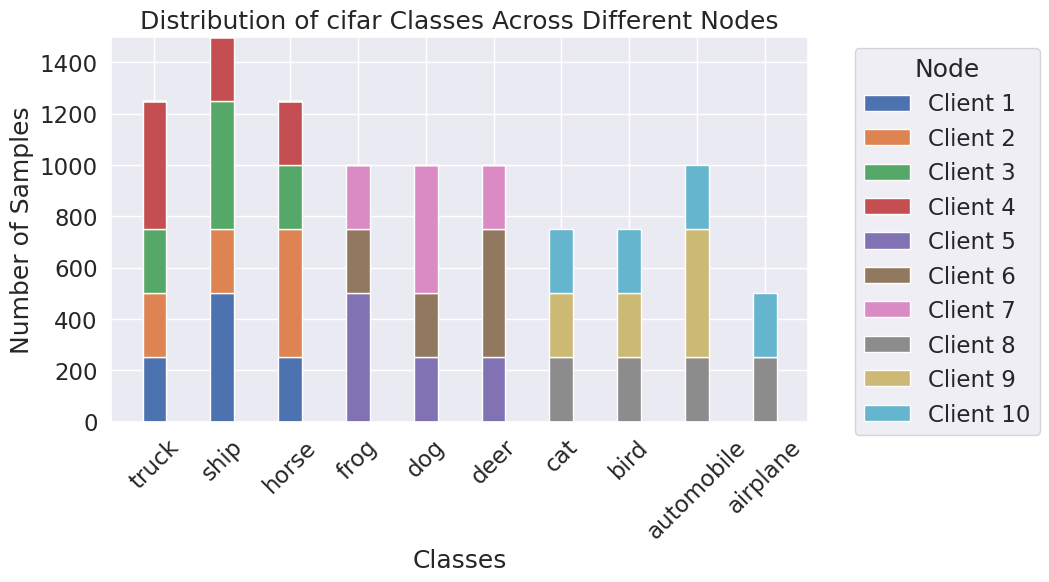

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

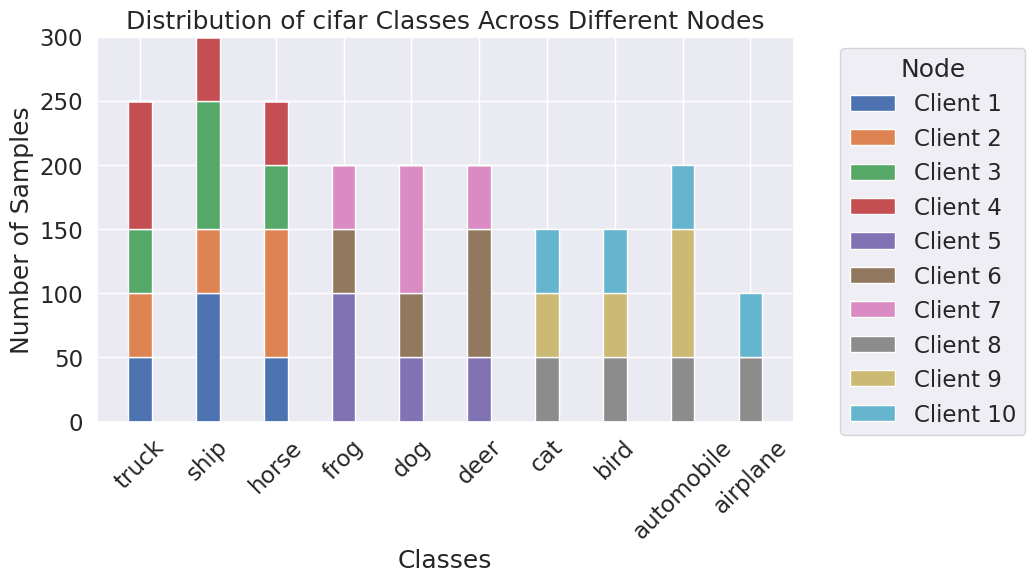

In [19]:
Visualizer(trainloaders).plot_class_distribution()

Visualizer(testloaders).plot_class_distribution()

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Executing</div>

In [20]:
clusters=[]

initial = [i for i in range(num_clients)]

clusters.append(initial)



#client_IDs=[6,4,2,1,3]



def generate_initial_models(step,cluster,client_IDs,client_Models):

    print("-------------in initial genertaio")

    print("cluster", cluster)

    print("clientIDs", client_IDs)

    print("len_client_models(should be 10):",len(client_Models))

    list1=[]



    if step==0:

        for member in range(len(cluster)):

            list1.append(Net())

    else:

        for index in cluster:

            list1.append(client_Models[client_IDs.index(index)])

    return list1



## ---------------main



client_Models=[]

client_copy_models = []



for step in range(Clustering_period):

    client_copy_models=copy.deepcopy(client_Models)

    client_Models=[]

    print("\n\n---------Clustering step", step)

    FL_list=[]

    client_IDs=[]
    for cluster in clusters:

        for Id in cluster:

            client_IDs.append(Id)

        cluster_initial_models=generate_initial_models(step,cluster,client_IDs,client_copy_models)

        print(" ---in making new FL----cluster models len:", len(cluster_initial_models),"cluster IDs:", client_IDs)

        #print("lencluster", len(cluster_initial_models))

        f = FL(cluster,cluster_initial_models,FL_rounds, trainloaders, testloaders, Sensitivity_percentage)

        FL_list.append(f)

        #plot_accuracy(f.accuracies, str(cluster))

        for member in f.client_obj_list:

            client_Models.append(member.net)

        ## Save pytorch models for each client

        for cid in client_IDs:

            save_torch_model(client_Models[client_IDs.index(cid)], cid)

            save_model_param(client_Models[client_IDs.index(cid)], cid, step)
    
    print("----------------------Info before clustering-------------")

    print("model_len:", len(client_Models))

    print("Client IDS:",client_IDs )

    start_cluster_time = datetime.now()

    clusters = Clustering(client_IDs, trainloaders, Sensitivity_percentage, cluster_number).Clusters

    end_cluster_time = datetime.now()

    exe_cluster_time = end_cluster_time - start_cluster_time

    with open(log_file, 'a') as f:

        f.write(f"\n Exe Cluster Time: {exe_cluster_time}")

    print("new clustering:",clusters)



---------Clustering step 0
-------------in initial genertaio
cluster [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
clientIDs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len_client_models(should be 10): 0
 ---in making new FL----cluster models len: 10 cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cid is: 0
cid is: 1
cid is: 2
cid is: 3
cid is: 4
cid is: 5
cid is: 6
cid is: 7
cid is: 8
cid is: 9

Round 1/6
_____________________________________________________________________________________________________________
node 0: train_acc: 0.347, test_acc:0.305
_____________________________________________________________________________________________________________
node 1: train_acc: 0.118, test_acc:0.02
_____________________________________________________________________________________________________________
node 2: train_acc: 0.18, test_acc:0.275
_____________________________________________________________________________________________________________
node 3: train_acc: 0.178, test_acc:0.26
___________________

KeyboardInterrupt: 